In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import sympy
%matplotlib inline

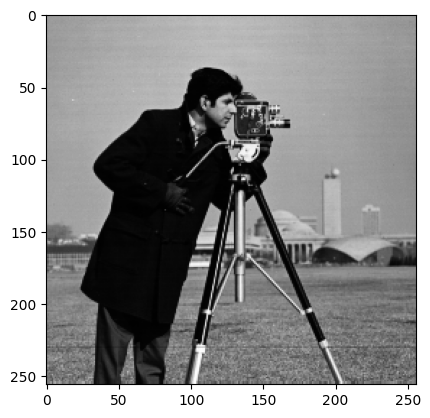

(256, 256)


In [11]:
# Load the .mat file into a dictionary
mat_data = scipy.io.loadmat('SampleImages/camera256.mat')

# Extract the image data from the dictionary
image_data = mat_data['camera256']

# Display the image using Matplotlib
plt.imshow(image_data, cmap='gray')
plt.axis('on')
plt.show()



In [23]:
# Separate image into 8x8 blocks
block_size = 8
blocks = []
for i in range(0, image_data.shape[0], block_size):
    for j in range(0, image_data.shape[1], block_size):
        blocks.append(image_data[i:i+block_size, j:j+block_size])

# Convert blocks to numpy array
blocks = np.array(blocks)
blocks = blocks - 128


In [ ]:
#Apply 2 dimensional DCT to each block

dct_blocks = []
for i in range(blocks.shape[0]):
    dct_blocks.append(scipy.fftpack.dctn(blocks[i], norm='ortho'))
dct_blocks = np.array(dct_blocks)

# Quantize the DCT coefficients

quantization_matrix = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
                                [12, 12, 14, 19, 26, 58, 60, 55],
                                [14, 13, 16, 24, 40, 57, 69, 56],
                                [14, 17, 22, 29, 51, 87, 80, 62],
                                [18, 22, 37, 56, 68, 109, 103, 77],
                                [24, 35, 55, 64, 81, 104, 113, 92],
                                [49, 64, 78, 87, 103, 121, 120, 101],
                                [72, 92, 95, 98, 112, 100, 103, 99]])